In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torchvision

from core import BinMNIST

In [3]:
class IsingModel2D:
    def __init__(self, img):
        self.w, self.h = img.shape
        self.device = img.device
        self.img = img*2 - 1
        self.spins = img*2 - 1
        self.dims = 2*torch.ones_like(self.spins, dtype=torch.int).to(self.device)
        self.eta = 2.1
        self.beta = 1.0
        
    def get_state(self):
        return (self.spins > 0).int()
    
    def set_state(self, state):
        self.spins = (2*state-1).to(self.device)
        
    def get_log_prob(self):
        w,h = self.w, self.h
        energy = -self.beta*torch.sum(self.spins[:,:w-1]*self.spins[:,1:])
        energy += -self.beta*torch.sum(self.spins[:h-1,:]*self.spins[1:,:])
        energy += -self.eta*torch.sum(self.spins*self.img)
        return -energy
        
    def get_cond_prob(self):
        w,h = self.w, self.h
        cond_energy = torch.zeros_like(self.spins).to(self.device)
        cond_energy[:,:w-1] += self.spins[:,1:]
        cond_energy[:,1:] += self.spins[:,:w-1]
        cond_energy[:h-1,:] += self.spins[1:,:]
        cond_energy[1:,:] += self.spins[:h-1,:]
        cond_energy = -self.beta*cond_energy - self.eta*self.img
        cond_log_prob = -cond_energy - torch.logaddexp(cond_energy,-cond_energy)
        cond_prob = torch.exp(cond_log_prob)
        cond_prob = cond_prob*(self.spins > 0) + (1-cond_prob)*(self.spins < 0)
        return cond_prob

In [4]:
class DGibbs:
    def __init__(self, distribution, v_coeffs=None):
        assert hasattr(distribution, 'get_log_prob')
        assert hasattr(distribution, 'get_state')
        assert hasattr(distribution, 'set_state')
        assert hasattr(distribution, 'dims')
        assert hasattr(distribution, 'get_cond_prob')
        self.dist = distribution
        self.device = distribution.device
        self.dims = self.dist.dims.flatten()
        self.state = self.dist.get_state().clone().flatten()
        self.x = self.state.clone()
        self.v_coeffs = v_coeffs
        if self.v_coeffs is None:
            self.v = torch.ones_like(self.state).to(self.device)
        else:
            self.v = self.v_coeffs.to(self.device)
        self.v = self.v/self.dist.get_cond_prob().flatten()
        self.dist_to_border = torch.ones_like(self.v)
        self.samples = []
        self.weights = []
        self.trajectory = [self.state.clone()]
        
    def iterate(self):
        # evaluate time
        time_until_border = self.dist_to_border/self.v
        iterate_time = torch.min(time_until_border)
        change_dim = torch.argmin(time_until_border)
        # update coordinates
        self.x = (self.x + self.v*iterate_time) % self.dims
        self.state[change_dim] = (self.state[change_dim]+1) % self.dims[change_dim]
        self.dist_to_border = self.dist_to_border - self.v*iterate_time
        self.dist_to_border[change_dim] = 1.0
        # put into samples
        self.samples.append(self.state.clone().cpu())
        self.weights.append(iterate_time.cpu())
        self.trajectory.append(self.x.clone().cpu())
        # update state
        self.dist.set_state(self.state.reshape(self.dist.dims.shape).clone())
        if self.v_coeffs is None:
            self.v = torch.ones_like(self.state).to(self.device)
        else:
            self.v = self.v_coeffs.to(self.device)
        self.v = self.v/self.dist.get_cond_prob().flatten()
        
class Gibbs:
    def __init__(self, distribution):
        assert hasattr(distribution, 'get_log_prob')
        assert hasattr(distribution, 'get_state')
        assert hasattr(distribution, 'set_state')
        assert hasattr(distribution, 'dims')
        assert hasattr(distribution, 'get_cond_prob')
        self.dist = distribution
        self.device = self.dist.device
        self.dims = self.dist.dims.flatten()
        self.state = self.dist.get_state().clone().flatten()
        self.samples = []
        self.weights = []
        self.change_dim = 0
        
    def iterate(self):
        cond_prob = self.dist.get_cond_prob().flatten()
        # update coordinates
        u = torch.empty([1]).uniform_().to(self.device)
        if u > cond_prob[self.change_dim]:
            self.state[self.change_dim] = (self.state[self.change_dim]+1) % self.dims[self.change_dim]
        # put into samples
        self.samples.append(self.state.clone())
        self.weights.append(torch.tensor(1.0))
        # update state
        self.dist.set_state(self.state.reshape(self.dist.dims.shape).clone())
        self.change_dim = (self.change_dim + 1) % self.state.shape[0]
        
def generate_primes(until_n):
    all_numbers = np.arange(until_n)
    prime_numbers = []
    for i in range(2,np.ceil(np.sqrt(until_n)).astype(int)):
        prime_numbers.append(i)
        all_numbers[::i] = -1.0
    prime_numbers = np.array(prime_numbers)
    return np.concatenate([prime_numbers, all_numbers[all_numbers > 0][1:]])

In [5]:
mnist_dataset = BinMNIST.BinMNIST('./data/binMNIST', train=True, 
                                  transform=torchvision.transforms.ToTensor(), download=True)
primes = generate_primes(100000)
print('prime numbers generated:', len(primes))
coeffs = torch.from_numpy(np.sqrt(primes)[:784])

prime numbers generated: 9842


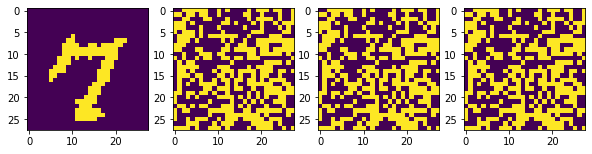

In [15]:
img, label = mnist_dataset[4]
img = img.squeeze(0)
noise = torch.empty_like(img).uniform_() > 0.9
noisy_img = (img+noise) % 2
device = torch.device('cuda:0')
noisy_img = noisy_img.to(device)

ising_dist_d = IsingModel2D(noisy_img.clone())
ising_dist_s = IsingModel2D(noisy_img.clone())
ising_dist = IsingModel2D(noisy_img.clone())

pure_noise = torch.empty_like(img).uniform_() > 0.5
ising_dist_d.set_state(pure_noise.clone())
ising_dist_s.set_state(pure_noise.clone())
ising_dist.set_state(pure_noise.clone())

gibbs_d = DGibbs(ising_dist_d, v_coeffs=coeffs)
suzuki = DGibbs(ising_dist_s)
gibbs = Gibbs(ising_dist)

figsize(10,5)
plt.subplot(141)
plt.imshow(img.numpy())
plt.subplot(142)
plt.imshow(gibbs.dist.spins.cpu().numpy())
plt.subplot(143)
plt.imshow(gibbs_d.dist.spins.cpu().numpy())
plt.subplot(144)
plt.imshow(suzuki.dist.spins.cpu().numpy())
plt.show()

In [16]:
n_iter = 20000
probs_d = np.zeros(n_iter)
probs_s = np.zeros(n_iter)
probs = np.zeros(n_iter)
for i in range(n_iter):
    probs_d[i] = gibbs_d.dist.get_log_prob()
    gibbs_d.iterate()
    probs_s[i] = suzuki.dist.get_log_prob()
    suzuki.iterate()
    probs[i] = gibbs.dist.get_log_prob()
    gibbs.iterate()

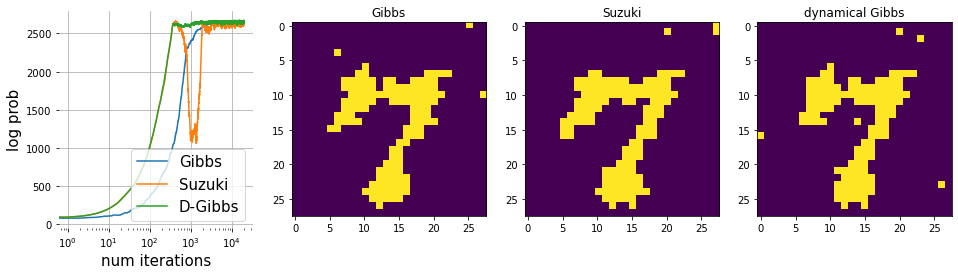

In [17]:
figsize(16,4)
plt.subplot(141)
plt.plot(probs, label='Gibbs')
plt.plot(probs_s, label='Suzuki')
plt.plot(probs_d, label='D-Gibbs')
plt.ylabel('log prob', fontsize=15)
plt.xlabel('num iterations', fontsize=15)
plt.xscale('log')
plt.box(False)
plt.legend(fontsize=15)
plt.grid()
plt.subplot(142)
plt.imshow(gibbs.dist.get_state().cpu().numpy())
plt.title('Gibbs')
plt.subplot(143)
plt.imshow(suzuki.dist.get_state().cpu().numpy())
plt.title('Suzuki')
plt.subplot(144)
plt.imshow(gibbs_d.dist.get_state().cpu().numpy())
plt.title('dynamical Gibbs')
plt.show()

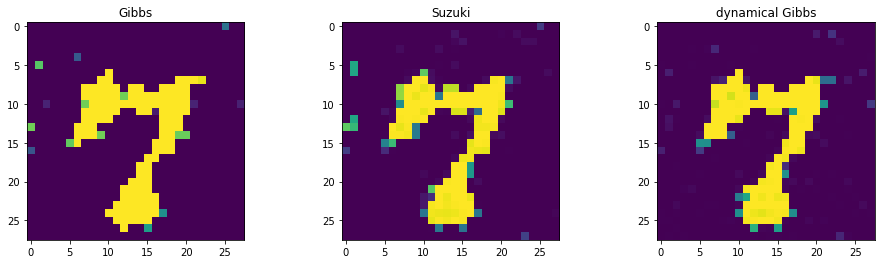

In [18]:
def get_mean_sample(sampler, n_last):
    samples = torch.stack(sampler.samples[-n_last:]).cpu().numpy()
    weights = torch.stack(sampler.weights[-n_last:]).cpu().numpy().reshape([-1,1])
    mean_sample = np.mean(samples*weights, axis=0).reshape(sampler.dist.img.shape)
    return mean_sample

n_last = 1000
mean_sample_gibbs = get_mean_sample(gibbs, n_last)
mean_sample_d = get_mean_sample(gibbs_d, n_last)
mean_sample_s = get_mean_sample(suzuki, n_last)

plt.subplot(131)
plt.imshow(mean_sample_gibbs)
plt.title('Gibbs')
plt.subplot(132)
plt.imshow(mean_sample_s)
plt.title('Suzuki')
plt.subplot(133)
plt.imshow(mean_sample_d)
plt.title('dynamical Gibbs')
plt.show()